In [45]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
from scipy import special
from sklearn.model_selection import train_test_split
import random
from save_csv import results_to_csv
random.seed(189)
np.random.seed(189)



In [46]:
def preProcess(data):
    np.random.seed(189)
    training_data, training_labels = data['X'], data['y'].flatten()
    test_data = data['X_test']

    print("Training data shape:", training_data.shape)
    print("Training labels shape:", training_labels.shape)
    print("Test data shape:", test_data.shape)

    training_data, validation_data, training_labels, validation_labels = train_test_split(training_data, training_labels, test_size=0.2, random_state=189)

    #normalize
    mean = training_data.mean(axis = 0)
    std = training_data.std(axis=0) + 1e-10
    training_data = (training_data - mean) / std
    validation_data = (validation_data - mean) / std
    test_data = (test_data - mean) / std

    #bias term
    training_data = np.hstack([np.ones((training_data.shape[0], 1)), training_data])
    validation_data = np.hstack([np.ones((validation_data.shape[0], 1)), validation_data])
    test_data = np.hstack([np.ones((test_data.shape[0], 1)), test_data])

    print("Training data shape after split:", training_data.shape)
    print("Validation data shape:", validation_data.shape)

    return training_data, validation_data, training_labels, validation_labels, test_data

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def j(x, y, w, r):
    s = sigmoid(x@w)
    regularization = (r/2)* np.sum(w[:-1]**2)
    loss = - np.sum(y * np.log(s + 1e-10) + (1 - y) * np.log(1 - s + 1e-10)) / len(y)

    return regularization + loss

def batch_update(x, y, w, r, e):
    s = sigmoid(x@w)
    gradient = x.T @(s-y)
    gradient[:-1] += r * w[:-1]
    return w - e* gradient


def train_bgd(training_data, training_labels, validation_data, validation_labels, r, e, num):

    w = np.zeros(training_data.shape[1])  
    train_cost_history = []
    value_cost_history = []
    for i in range(num):
        train_cost = j(training_data, training_labels, w, r)
        train_cost_history.append(train_cost)

        value_cost = j(validation_data, validation_labels, w, r)
        value_cost_history.append(value_cost)

        w = batch_update(training_data,training_labels,w,r,e)

    return w, train_cost_history, value_cost_history

def predict(x, w):
    return np.where(sigmoid(x @ w) >= 0.5, 1, 0)

def accuracy(x, y, w):
    preds = predict(x, w)
    return np.mean(preds == y)

Training data shape: (5000, 12)
Training labels shape: (5000,)
Test data shape: (1000, 12)
Training data shape after split: (4000, 13)
Validation data shape: (1000, 13)
Final Training Accuracy:   0.9955
Final Validation Accuracy: 0.9970


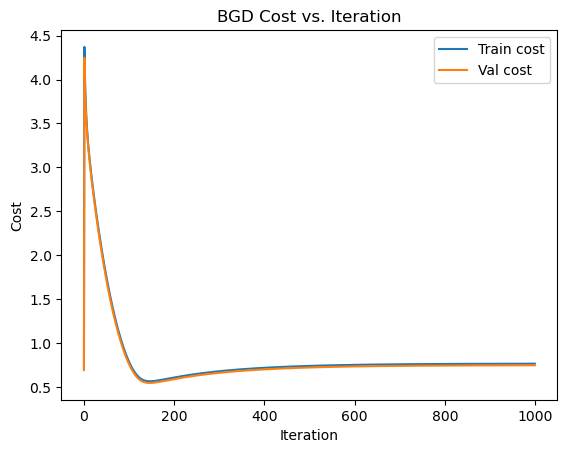

In [51]:
data = io.loadmat('data.mat')

training_data, validation_data, training_labels, validation_labels, test_data = preProcess(data)
#r = 0.1, e = 0.01 diverge
r = 0.01
e = 0.01 
num = 1000 
w, train_cost_history, val_cost_history = train_bgd(training_data, training_labels, validation_data, validation_labels,r,e,num)
acc_train = accuracy(training_data, training_labels, w)
acc_val   = accuracy(validation_data, validation_labels, w)

print(f"Final Training Accuracy:   {acc_train:.4f}")
print(f"Final Validation Accuracy: {acc_val:.4f}")

plt.figure()
plt.plot(train_cost_history, label='Train cost')
plt.plot(val_cost_history, label='Val cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.title('BGD Cost vs. Iteration')
plt.show()




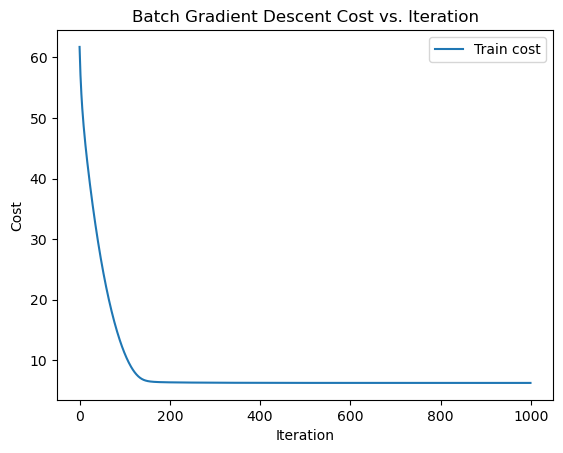

In [40]:
def train_bgd_all(data, label, r, e, num):
    w = np.zeros(data.shape[1], dtype=float)
    cost_history = []
    
    for i in range(num):
        w = batch_update(data, label, w, r, e)
        cost_train = j(data, label, w, r)
        cost_history.append(cost_train)

    return w, cost_history

data = io.loadmat('data.mat')
X_all = data['X']        
y_all = data['y'].flatten()
X_test = data['X_test']

mean = X_all.mean(axis=0)
std = X_all.std(axis=0) + 1e-10
X_all_norm = (X_all - mean) / std
X_test_norm = (X_test - mean) / std

X_all_norm = np.hstack([np.ones((X_all_norm.shape[0], 1)), X_all_norm])
X_test_norm = np.hstack([np.ones((X_test_norm.shape[0], 1)), X_test_norm])

r = 0.1
e = 0.01        
num = 1000

w_all, cost_history = train_bgd_all(X_all_norm, y_all, r, e, num)
y_test_pred = predict(X_test_norm, w_all)

results_to_csv(y_test_pred, "wine-submission.csv")
plt.figure()
plt.plot(cost_history, label="Train cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.title("Batch Gradient Descent Cost vs. Iteration")
plt.show()

In [41]:
def sgd_update(x_i, y_i, w, r, e):
    s = sigmoid(x_i@w)
    gradient = (s-y_i)*x_i
    gradient[:-1] += r * w[:-1]
    return w - e* gradient


def train_sgd(training_data, training_labels, validation_data, validation_labels, r, e, num):
    random.seed(189)
    w = np.zeros(training_data.shape[1])  
    train_cost_history = []
    value_cost_history = []
    for i in range(num):
        data = np.column_stack((training_data, training_labels))
        np.random.shuffle(data)
        training_data, training_labels = data[:, :-1], data[:, -1]

        for i in range(len(training_data)):
            w = sgd_update(training_data[i], training_labels[i], w, r, e)
            
        train_cost = j(training_data, training_labels, w, r)
        train_cost_history.append(train_cost)

        value_cost = j(validation_data, validation_labels, w, r)
        value_cost_history.append(value_cost)

    return w, train_cost_history, value_cost_history

Training data shape: (5000, 12)
Training labels shape: (5000,)
Test data shape: (1000, 12)
Training data shape after split: (4000, 13)
Validation data shape: (1000, 13)
Final Training Accuracy:   0.9875
Final Validation Accuracy: 0.9940


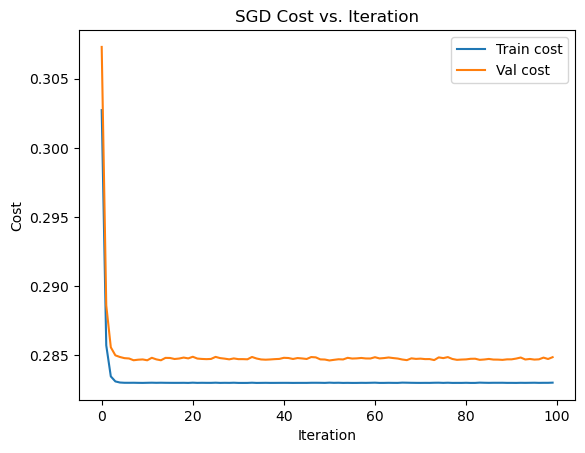

In [43]:
data = io.loadmat('data.mat')

training_data, validation_data, training_labels, validation_labels, test_data = preProcess(data)
r = 0.1
e = 0.001 
num = 100 
w, train_cost_history, val_cost_history = train_sgd(training_data, training_labels, validation_data, validation_labels,r,e,num)
acc_train = accuracy(training_data, training_labels, w)
acc_val   = accuracy(validation_data, validation_labels, w)

print(f"Final Training Accuracy:   {acc_train:.4f}")
print(f"Final Validation Accuracy: {acc_val:.4f}")

plt.figure()
plt.plot(train_cost_history, label='Train cost')
plt.plot(val_cost_history, label='Val cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.title('SGD Cost vs. Iteration')
plt.show()




Training data shape: (5000, 12)
Training labels shape: (5000,)
Test data shape: (1000, 12)
Training data shape after split: (4000, 13)
Validation data shape: (1000, 13)
Final Training Accuracy:   0.9673
Final Validation Accuracy: 0.9700


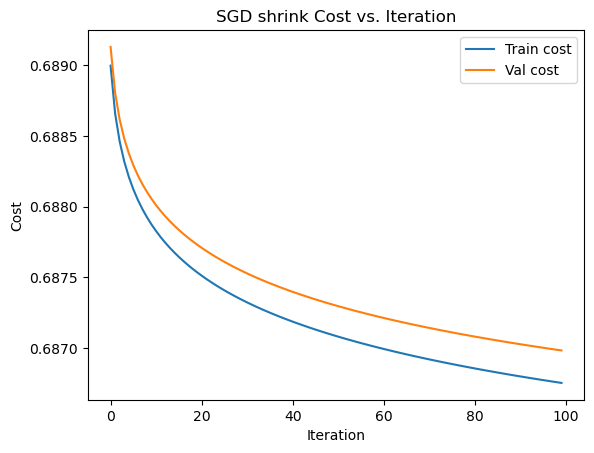

In [44]:
def train_sgd_shrink_stepsize(training_data, training_labels, validation_data, validation_labels, r, e, num):
    random.seed(189)
    w = np.zeros(training_data.shape[1])  
    train_cost_history = []
    value_cost_history = []
    
    iterations = 1
    for i in range(num):
        data = np.column_stack((training_data, training_labels))
        np.random.shuffle(data)
        training_data, training_labels = data[:, :-1], data[:, -1]

        for i in range(len(training_data)):
            e_i = e/iterations
            w = sgd_update(training_data[i], training_labels[i], w, r, e_i)
            iterations += 1
            
        train_cost = j(training_data, training_labels, w, r)
        train_cost_history.append(train_cost)

        value_cost = j(validation_data, validation_labels, w, r)
        value_cost_history.append(value_cost)

    return w, train_cost_history, value_cost_history

data = io.loadmat('data.mat')

training_data, validation_data, training_labels, validation_labels, test_data = preProcess(data)
r = 0.1
e = 0.001 
num = 100 
w, train_cost_history, val_cost_history = train_sgd_shrink_stepsize(training_data, training_labels, validation_data, validation_labels,r,e,num)
acc_train = accuracy(training_data, training_labels, w)
acc_val   = accuracy(validation_data, validation_labels, w)

print(f"Final Training Accuracy:   {acc_train:.4f}")
print(f"Final Validation Accuracy: {acc_val:.4f}")

plt.figure()
plt.plot(train_cost_history, label='Train cost')
plt.plot(val_cost_history, label='Val cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.title('SGD shrink Cost vs. Iteration')
plt.show()


